# Wrapping up our CNN

First of all, don't worry: this is meant to take a while!

Also we cover software engineering because we think that data scientists should be good software engineers.

Today we're going to start to move from a minimal training loop to something that is SoTA on ImageNet, things we'll cover:

- Cuda
- Convolutions
- Hooks
- Normalization
- Transforms
- Data Blocks
- Label Smoothing
- Optimization
- Weight Decay
- Skip Connection Architectures

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Callbacks

### Callbacks as GUI events

In [7]:
import ipywidgets as widgets

In [8]:
def f(o):
    print('hi')

In [9]:
w = widgets.Button(description='Click Me')

In [10]:
w

Button(description='Click Me', style=ButtonStyle())

hi
hi


In [11]:
w.on_click(f)

Meaning, when a click event occurs, **callback** to the function f.

### Creating Your Own Callback

In [12]:
from time import sleep

In [13]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [14]:
slow_calculation()

30

Imagine yourself training a deep learning model, you really want to know how it's going. We simulated slow loops by writing `slow_calculation()` and now we're going to inject a call back to check how it's doing while running:

In [15]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb:
            cb(i)
    return res

In [16]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [17]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

### Lambdas & Partials

In [18]:
slow_calculation(lambda epoch: print(f"Awesome! We've finished epoch {epoch}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [20]:
def show_progress(exclamation, epoch):
    print(f"{exclamation} We've finished epoch {epoch}!")

In [21]:
slow_calculation(lambda epoch: show_progress("OK I guess", epoch))

OK I guess We've finished epoch 0!
OK I guess We've finished epoch 1!
OK I guess We've finished epoch 2!
OK I guess We've finished epoch 3!
OK I guess We've finished epoch 4!


30

In [25]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [28]:
slow_calculation(make_show_progress("Nice"))

Nice! We've finished epoch 0!
Nice! We've finished epoch 1!
Nice! We've finished epoch 2!
Nice! We've finished epoch 3!
Nice! We've finished epoch 4!


30

You might see it done like this instead:

In [29]:
def make_show_progress(exclamation):
    def _inner(epoch):
        print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [30]:
slow_calculation(make_show_progress("Nice"))

Nice! We've finished epoch 0!
Nice! We've finished epoch 1!
Nice! We've finished epoch 2!
Nice! We've finished epoch 3!
Nice! We've finished epoch 4!


30

In [31]:
slow_calculation(make_show_progress("Amazing"))

Amazing! We've finished epoch 0!
Amazing! We've finished epoch 1!
Amazing! We've finished epoch 2!
Amazing! We've finished epoch 3!
Amazing! We've finished epoch 4!


30

Because this feature is used soo much, python has `partials`:

In [33]:
from functools import partial

In [34]:
slow_calculation(partial(show_progress, "OK I guess"))

OK I guess We've finished epoch 0!
OK I guess We've finished epoch 1!
OK I guess We've finished epoch 2!
OK I guess We've finished epoch 3!
OK I guess We've finished epoch 4!


30

In [35]:
f2 = partial(show_progress, "OK I guess")

In [36]:
slow_calculation(f2)

OK I guess We've finished epoch 0!
OK I guess We've finished epoch 1!
OK I guess We've finished epoch 2!
OK I guess We've finished epoch 3!
OK I guess We've finished epoch 4!


30

### Callbacks as Callable Classes

In [37]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"):
        self.exclamation = exclamation
    
    def __call__(self, epoch):
        print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [38]:
cb = ProgressShowingCallback("Just Super")

In [39]:
slow_calculation(cb)

Just Super! We've finished epoch 0!
Just Super! We've finished epoch 1!
Just Super! We've finished epoch 2!
Just Super! We've finished epoch 3!
Just Super! We've finished epoch 4!


30

### Multiple callback funcs; `*args` and `**kwargs`

In [40]:
def f(*args, **kwargs):
    print(f"args: {args}; kwargs: {kwargs}")

In [41]:
f(3, 'a', thing1='Hello')

args: (3, 'a'); kwargs: {'thing1': 'Hello'}


In [42]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb:
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb:
            cb.after_calc(i, val=res)
    return res

Let's create a callback class for the function:

In [43]:
class PrintStepCallBack():
    def __init__(self):
        pass
    
    def before_calc(self, *args, **kwargs):
        print(f"About to start")
    
    def after_calc(self, *args, **kwargs):
        print(f"Done step")

In [44]:
slow_calculation(PrintStepCallBack())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In the previous example we didn't get an error because we used `*args` and `**kwargs`, effectively ignoring the passed parameters.

Let's now use them:

In [45]:
class PrintStatusCallBack():
    def __init__(self):
        pass
    
    def before_calc(self, epoch, **kwargs):
        print(f"About to start: {epoch}")
    
    def after_calc(self, epoch, val, **kwargs):
        print(f"Done step {epoch}: {val}")

In [46]:
slow_calculation(PrintStatusCallBack())

About to start: 0
Done step 0: 0
About to start: 1
Done step 1: 1
About to start: 2
Done step 2: 5
About to start: 3
Done step 3: 14
About to start: 4
Done step 4: 30


30

`**kwargs` are kept because we might add other parameters in the future and we don't want to break if the user added non-existing parameters, it makes the class more resilient.

### Modifying Behavior

In [56]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, "before_calc"):
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, "after_calc"):
            if cb.after_calc(i, val=res):
                print("Stopping early")
                break
    return res

In [67]:
class PrintAfterCallBack():
    def after_calc(self, epoch, val, **kwargs):
        print(f"Done step {epoch}: {val}")
        if val > 10:
            return True

In [68]:
slow_calculation(PrintAfterCallBack())

Done step 0: 0
Done step 1: 1
Done step 2: 5
Done step 3: 14
Stopping early


14

Next, we want to alter the calculation itself:

In [69]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb = cb
        self.res = 0
    
    def callback(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)
    
    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print("Stopping Early")
                break

In [70]:
class ModifyingCallBack():
    def after_calc(self, calc, epoch):
        print(f"After epoch {epoch}: {calc.res}")
        if calc.res > 10:
            return True
        if calc.res < 3:
            calc.res = calc.res*2

In [74]:
calculator = SlowCalculator(ModifyingCallBack())

In [75]:
calculator.calc()

After epoch 0: 0
After epoch 1: 1
After epoch 2: 6
After epoch 3: 15
Stopping Early


This represent the extend of our callback functionalities that we use in FastAI.

### `__dunder__` thingies

In [76]:
class SloppyAdder():
    def __init__(self, o):
        self.o = o
    
    def __add__(self, b):
        return SloppyAdder(self.o + b.o + 0.01)
    
    def __repr__(self):
        return str(self.o)

In [77]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a + b

3.01

Special Methods I should know:

- [x] __getitem__
- [ ] __getattr__
- [ ] __setattr__
- [ ] __del__
- [x] __init__
- [ ] __new__
- [ ] __enter__
- [ ] __exit__
- [x] __len__
- [x] __repr__
- [ ] __str__

## Browsing Source Code

Learn to do these things in our editor of choice:

- [ ] Jump to tag/symbol by with (with completion)
    - Symbol: class/fucntion/...
- [ ] Jump to current tag
    - By clicking on the tag
- [ ] Jump to library tags
- [ ] Go back
    - To the place you were working in (in the file)
- [ ] Search
- [ ] Outlining/Folding

## Variance & Stuff

### Variance

Variance is the average of how far each data point is from the mean $\mu$.

In [78]:
t = torch.Tensor([1., 2., 4., 18.])

In [79]:
m = t.mean(); m

tensor(6.2500)

In [80]:
(t-m).mean()

tensor(0.)

We can't do that because all of the negative/positive differences cancel-out, so we can fix that in one of two ways:

In [81]:
(t-m).pow(2).mean()

tensor(47.1875)

The **mean absolute deviation**:

In [84]:
# Or..
(t-m).abs().mean()

tensor(5.8750)

Let's undo the squaring that happened for the first solution, we present the **standard deviation**:

In [85]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

they're still different, why?

Because of the squaring mechanism, standard deviation is more sensitive to outliers.

Here's a useful thing to note about variance:

In [86]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

Or:

$$Var(X)=\frac{1}{m}\sum_{i=1}^{m}x_{i}^{2}-\mu^2=E[X^2]-E[X]^2$$

The important thing is that this formula is much more easier to work with. In particular, you only have to track two things:

1. The sum of the data
2. The sum of squares of the data

Whereas in the original formula you have to go through all of the data twice, once to calculate the mean & once to calculate the variance.

### Covariance & Correlation 

Here's how wikipedia defines covariance:

$$Cov(X,Y)=E[(X-E[X])(Y-E[Y])]$$

In [89]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code, So now we need two vectors:

In [90]:
# `u` is twice as `t` plus a little bit of randomness
u = t * 2 
u += torch.randn_like(t)/10+0.95

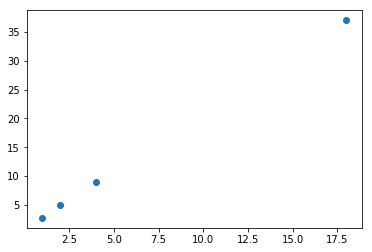

In [91]:
plt.scatter(t, u)

In [92]:
prod = (t-t.mean())*(u-u.mean())
prod

tensor([ 55.8334,  36.0556,  10.0787, 277.2768])

In [93]:
prod.mean()

tensor(94.8111)

Let's compare the previous average with the next:

In [94]:
v = torch.randn_like(t)

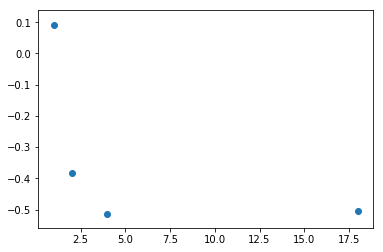

In [95]:
plt.scatter(t, v)

In [96]:
prod = (t-t.mean())*(v-v.mean())
prod

tensor([-2.2009,  0.2400,  0.4184, -2.0770])

In [97]:
prod.mean()

tensor(-0.9048)

Covariance tells you how random variables vary jointly, you can also calculate it as follows:

$$Cov(X,Y)=E[XY]-E[X]E[Y]$$

In [99]:
cov = (t*u).mean() - (t.mean()*u.mean())
cov

tensor(94.8111)

Finally, here is the pearson correlation coefficient:

$$p_{X,Y}=\frac{Cov(X,Y)}{\sigma_{X}\sigma_{Y}}$$

In [100]:
cov / (t.std() * u.std())

tensor(0.7500)

This is just a scaled version so that the output is $\in [-1,1]$.

Remember that Covariance and its pearson coefficient describe **linear** variations.

## Softmax

Here's our final `logsoftmax` definition:

In [102]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

Which is:

$$logsoftmax(x)_i=x_i - log\sum_{j}e^{x_j}$$

And our cross entropy loss is:

$$-log(p_i)$$

A big problem with softmax is that it **must** pick something, so even if the activation values of the last layer are negative (signaling the absence of all classes from an example image) the softmax function will force a probability distribution that sum up to one so that a class can be picked.

Another problem that happens is when you have multiple classes present in the image, in this case even the present classes will get minimized by the softmax function in favor of the class associated with the highest activation to be picked.

Meaning, softmax is terrible except if you definately know that, per image, you have only one and no more or less than one "class" present in the image.

If your not sure, use this:

$$S(x)=\frac{e^x}{1+{e^x}}$$

And because, for the most part, you won't be sure, **don't use softmax**. 

---